# Project 1 Development Notebook: Climate and Housing

This file contains development code for project 1 for ECON 1680. It contains all code required to replicate the results outlined in the draft. Inline citations are included for all code segments that are not original. The code first cleans the data, generates some descriptive statistics, and then leverages the methodology discussed in the paper: 
We use different regressions and dimension reduction techniques to analyze the relationship between climate risk and housing prices, using space as our source of variation.

## 1. Imports and Functions

In [1]:
import pandas as pd
import numpy as np
from dateutil.parser import parse
import matplotlib.pyplot as plt
import random
import statsmodels.api as sm
from math import sqrt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

random.seed(1680)

In [2]:
def is_date(string):
    # From https://stackoverflow.com/questions/25341945/check-if-string-has-date-any-format
    #   Checks if a string can be interpreted as a date
    try:
        parse(string)
        return True
    except ValueError:
        return False

In [3]:
def get_pct_change(row, start_date, end_date):
    # This function gets the percentage change in ZHVI from 2000-2019 for a given county.
    #   We use this later to generate one of our dependent variables.
    pct_change = (row[end_date] - row[start_date]) / row[start_date]
    return pct_change

In [4]:
def get_volatility(row, date_vars):
    # This function average of the yearly coefficients of variation in ZHVI in a county.
    coef_of_vars = []
    for n in range(0, len(date_vars), 12):
        year_vars = date_vars[n:n + 12]
        year_price_data = row[year_vars].tolist()

        # Drop year observations if we don't have sufficient data to calculate the coefficient of variation.
        if True not in [np.isnan(i) for i in year_price_data]:
            coef_of_vars.append(np.std(year_price_data) / np.mean(year_price_data))
        
    # If we have no information about volatility, return missing.
    if coef_of_vars == []:
        return np.nan
    return np.mean(coef_of_vars)

## 2. Data: Cleaning and Saving

In [5]:
# Path to production directory: note that you must include Data, Figures, and Code subdirectories.
path = "C:\\Users\\garvg\\Downloads\\Project 1\\ClimateAndHousing\\"

# Read in CSV data
zillow = pd.read_csv(path + "Data\\zillow.csv")
nri_fema = pd.read_csv(path + "Data\\nri_fema.csv")
oi_covars = pd.read_csv(path + "Data\\oi_covars.csv")

In [6]:
# Merge CSV data by State and County FIPS codes and save
clim_hous_data = zillow.merge(nri_fema, on=["state_fips", "county_fips"], validate="one_to_one")
all_data = clim_hous_data.merge(oi_covars, on=["state_fips", "county_fips"], validate="one_to_one")
all_data.to_csv(path + "Data\\all_data.csv", index=False)

In [7]:
# Specify columns to keep: hazard scores, controls, and house value
hazard_vars = [
    "Avalanche", "Coastal Flooding", "Cold Wave", "Drought", "Earthquake", 
    "Hail", "Heat Wave", "Hurricane", "Ice Storm", "Landslide", "Lightning",
    "Riverine Flooding", "Strong Wind", "Tornado", "Tsunami", "Volcanic Activity",
    "Wildfire", "Winter Weather"]
hazard_vars = [hazard + " - Hazard Type Risk Index Score" for hazard in hazard_vars]
hazard_vars.append("National Risk Index - Score - Composite")

housing_vars = [col for col in all_data.columns if is_date(col) and "202" not in col]
housing_vars.sort()

control_vars = [
    "Population (2020)", "Building Value ($)", "Agriculture Value ($)", "Area (sq mi)", "job_density_2013",
    "ann_avg_job_growth_2004_2013", "ln_wage_growth_hs_grad", "emp2000", "foreign_share2010", 
    "mean_commutetime2000", "frac_coll_plus2000", "frac_coll_plus2010", "hhinc_mean2000",
    "med_hhinc1990", "med_hhinc2016", "poor_share1990", "poor_share2000", "poor_share2010",
    "share_white2000", "share_black2000", "share_hisp2000", "share_asian2000",
    "share_white2010", "share_black2010", "share_hisp2010", "share_asian2010"
    ]

columns = ["State Name", "County Name", "state_fips", "county_fips"]
columns.extend(hazard_vars)
columns.extend(housing_vars)
columns.extend(control_vars)

all_data_pruned = all_data[columns]

In [8]:
# For hazard data, rename variables and replace missing values with zeroes:
#   Missing values imply that "Community is not considered at risk for hazard type."
#   according to the official NRI documentation here:
#   https://www.fema.gov/sites/default/files/documents/fema_national-risk-index_technical-documentation.pdf
hazard_rename_dict = dict()

for hazard in hazard_vars:
    hazard_rename_dict[hazard] = hazard[:hazard.index(" - ")]
    all_data_pruned[hazard] = all_data_pruned[hazard].fillna(0)

all_data_pruned = all_data_pruned.rename(hazard_rename_dict, axis=1)

C:\Users\garvg\AppData\Local\Temp\ipykernel_17188\2145004020.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_pruned[hazard] = all_data_pruned[hazard].fillna(0)


### Dependent Variable Generation

The NRI takes into account historical loss data from 1996-2019 when computing natural hazard risk. We can thus take the NRI as a measure of both hazard risk and historical hazard loss. This can be supported by the documentation, which is included here: https://www.fema.gov/sites/default/files/documents/fema_national-risk-index_technical-documentation.pdf. This will be corroborated later, as we will show that the incidence of certain natural disasters in South Carolina is strongly correlated with these risk indices.

We bring this up to explain that we will consider Zillow home value data (the Zillow Home Value Index, or ZHVI is our measure) from the years 2000 (earliest available) to 2019. Our dependent variables will thus be the following:
1. Mean house value over this period (to capture the relationship between risk and magnitude of housing prices)
2. Average percentage change in housing price (to capture the relationship between risk and long-term upward/downward trends)
3. Average within-year variance in housing price (to capture the relationship between risk and short-term housing price volatility)

We generate these values below.

In [9]:
# Generate mean ZHVI over 2000-2019
all_data_pruned["ZHVI_mean"] = all_data_pruned[housing_vars].mean(axis=1)

# Generate mean percentage change over 2000-2019
all_data_pruned["ZHVI_trend"] = all_data_pruned.apply(get_pct_change, args=("2000-01-31", "2019-12-31"), axis=1)

# Generate mean within-year (month-to-month) variance over 2000-2019
all_data_pruned["ZHVI_vol"] = all_data_pruned.apply(get_volatility, args=(housing_vars,), axis=1) 

In [10]:
# Drop unnecessary variables
all_data_pruned = all_data_pruned.drop(columns=housing_vars)

# Save data after cleaning
all_data_pruned.to_csv(path + "Data\\all_data_pruned.csv", index=False)

## 3. Descriptive Statistics

Note: After running the above code, we may always start here since the pre-processing steps are saved in the all_data_pruned.csv file.

In [11]:
# Load data
working_data = pd.read_csv(path + "Data\\all_data_pruned.csv")
working_data.head()

,State Name,County Name,state_fips,county_fips,Avalanche,Coastal Flooding,Cold Wave,Drought,Earthquake,Hail,...,share_black2000,share_hisp2000,share_asian2000,share_white2010,share_black2010,share_hisp2010,share_asian2010,ZHVI_mean,ZHVI_trend,ZHVI_vol
0,California,Los Angeles,6,37,33.653846,43.259557,0.000000,73.846643,100.000000,48.106904,...,0.100307,0.439193,0.105664,0.277873,0.089271,0.477450,0.121261,421124.410815,2.057027,0.034877
1,Illinois,Cook,17,31,0.000000,44.265594,100.000000,19.949093,96.659243,93.923003,...,0.242277,0.196171,0.046331,0.438595,0.249698,0.239623,0.056553,197042.801648,0.587883,0.020780
2,Texas,Harris,48,201,0.000000,73.843058,99.204582,88.450525,90.741330,94.050270,...,0.176150,0.307376,0.045832,0.329789,0.189457,0.408444,0.051969,140117.773455,0.856429,0.013150
3,Arizona,Maricopa,4,13,0.000000,0.000000,0.000000,85.841553,98.218263,99.331849,...,0.037874,0.243300,0.017987,0.586845,0.054242,0.295705,0.030152,206654.847968,1.082801,0.034382
4,California,San Diego,6,73,31.250000,32.796781,0.000000,89.564111,99.745466,22.589882,...,0.060665,0.260778,0.083679,0.484619,0.055997,0.320274,0.098978,424881.784092,1.785324,0.030891


In [12]:
# Generate map of hazard risk

# Generate map of housing prices

# Generate map of housing price trend

# Generate map of housing price volatility


In [13]:
# Write descriptive statistics to logfile
summary_statistics = working_data.describe()
summary_statistics.to_csv(path + '\\Figures\\Descriptive\\summary_statistics.csv', index_label='Metric')
summary_statistics.head()

,state_fips,county_fips,Avalanche,Coastal Flooding,Cold Wave,Drought,Earthquake,Hail,Heat Wave,Hurricane,...,share_black2000,share_hisp2000,share_asian2000,share_white2010,share_black2010,share_hisp2010,share_asian2010,ZHVI_mean,ZHVI_trend,ZHVI_vol
count,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,3073.000000,...,3073.000000,3073.000000,3050.000000,3073.000000,3073.000000,3073.000000,3059.000000,3005.000000,1034.000000,2988.000000
mean,30.279857,103.366417,3.230056,7.867445,46.351206,49.280821,50.595847,50.327553,49.254025,36.173363,...,0.088648,0.060585,0.007259,0.786937,0.094079,0.082362,0.009541,138742.559884,0.895186,0.016478
std,15.063746,107.779895,14.412471,21.809221,33.456454,30.498124,28.676059,28.770805,30.869760,33.256354,...,0.142850,0.116709,0.019129,0.192676,0.145760,0.129940,0.021505,80068.204022,0.418654,0.006075
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000820,0.000000,0.028604,0.000000,0.001311,0.000000,24942.839331,-0.134327,0.002858
25%,19.000000,35.000000,0.000000,0.000000,0.000000,25.167038,25.930640,25.389755,26.057906,0.000000,...,0.004115,0.009270,0.001705,0.673463,0.007189,0.016089,0.002425,91076.527040,0.598596,0.012313


## 4. Regressions

We use standard OLS estimation, LASSO, and Ridge regressions to capture both what variables are the most correlated and predictive of long-term trends, average magnitude, and short-term volatility in local housing prices.

In [14]:
# Create lists of independent (hr) and dependent (y) variables for analysis
hr_vars = [hazard_rename_dict[i] for i in hazard_vars]
hr_vars.remove("National Risk Index")
y_vars = ["ZHVI_mean", "ZHVI_trend", "ZHVI_vol"]

### OLS

We use this approach as a baseline estimator of the relationships between hazard risk and housing price characteristics.

In [15]:
# Conduct OLS Regression on mean ZHVI (without controls)
considered = hr_vars + ["ZHVI_mean"]
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_mean"]
working_xs = mod_working_data[hr_vars]

mean_ols_no_X = sm.OLS(working_ys, working_xs).fit()
print(mean_ols_no_X.summary())

                                 OLS Regression Results                                
Dep. Variable:              ZHVI_mean   R-squared (uncentered):                   0.818
Model:                            OLS   Adj. R-squared (uncentered):              0.817
Method:                 Least Squares   F-statistic:                              744.9
Date:                Sat, 09 Mar 2024   Prob (F-statistic):                        0.00
Time:                        02:50:56   Log-Likelihood:                         -37718.
No. Observations:                3005   AIC:                                  7.547e+04
Df Residuals:                    2987   BIC:                                  7.558e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [16]:
# Conduct OLS Regression on mean ZHVI (with controls)
considered = hr_vars + ["ZHVI_mean"] + control_vars
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_mean"]
working_xs = mod_working_data[hr_vars + control_vars]

mean_ols_X = sm.OLS(working_ys, working_xs).fit()
print(mean_ols_X.summary())

                            OLS Regression Results                            
Dep. Variable:              ZHVI_mean   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     193.8
Date:                Sat, 09 Mar 2024   Prob (F-statistic):               0.00
Time:                        02:50:56   Log-Likelihood:                -28077.
No. Observations:                2341   AIC:                         5.624e+04
Df Residuals:                    2297   BIC:                         5.650e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Avalanche       

In [17]:
# Conduct OLS Regression on change in ZHVI (without controls)
considered = hr_vars + ["ZHVI_trend"]
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_trend"]
working_xs = mod_working_data[hr_vars]

trend_ols_no_X = sm.OLS(working_ys, working_xs).fit()
print(trend_ols_no_X.summary())

                                 OLS Regression Results                                
Dep. Variable:             ZHVI_trend   R-squared (uncentered):                   0.840
Model:                            OLS   Adj. R-squared (uncentered):              0.837
Method:                 Least Squares   F-statistic:                              296.7
Date:                Sat, 09 Mar 2024   Prob (F-statistic):                        0.00
Time:                        02:50:56   Log-Likelihood:                         -506.89
No. Observations:                1034   AIC:                                      1050.
Df Residuals:                    1016   BIC:                                      1139.
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [18]:
# Conduct OLS Regression on change in ZHVI (with controls)
considered = hr_vars + ["ZHVI_trend"] + control_vars
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_trend"]
working_xs = mod_working_data[hr_vars + control_vars]

trend_ols_X = sm.OLS(working_ys, working_xs).fit()
print(trend_ols_X.summary())

                            OLS Regression Results                            
Dep. Variable:             ZHVI_trend   R-squared:                       0.592
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     27.56
Date:                Sat, 09 Mar 2024   Prob (F-statistic):          9.90e-130
Time:                        02:50:56   Log-Likelihood:                -102.63
No. Observations:                 862   AIC:                             293.3
Df Residuals:                     818   BIC:                             502.7
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Avalanche       

In [19]:
# Conduct OLS Regression on yearly volatility in ZHVI (without controls)
considered = hr_vars + ["ZHVI_vol"]
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_vol"]
working_xs = mod_working_data[hr_vars]

vol_ols_no_X = sm.OLS(working_ys, working_xs).fit()
print(vol_ols_no_X.summary())

                                 OLS Regression Results                                
Dep. Variable:               ZHVI_vol   R-squared (uncentered):                   0.858
Model:                            OLS   Adj. R-squared (uncentered):              0.857
Method:                 Least Squares   F-statistic:                              993.4
Date:                Sat, 09 Mar 2024   Prob (F-statistic):                        0.00
Time:                        02:50:56   Log-Likelihood:                          10749.
No. Observations:                2988   AIC:                                 -2.146e+04
Df Residuals:                    2970   BIC:                                 -2.135e+04
Df Model:                          18                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [20]:
# Conduct OLS Regression on yearly volatility in ZHVI (with controls)
considered = hr_vars + ["ZHVI_vol"] + control_vars
mod_working_data = working_data.dropna(subset=considered)

working_ys = mod_working_data["ZHVI_vol"]
working_xs = mod_working_data[hr_vars + control_vars]

vol_ols_X = sm.OLS(working_ys, working_xs).fit()
print(vol_ols_X.summary())

                            OLS Regression Results                            
Dep. Variable:               ZHVI_vol   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     26.19
Date:                Sat, 09 Mar 2024   Prob (F-statistic):          1.18e-165
Time:                        02:50:56   Log-Likelihood:                 9018.0
No. Observations:                2330   AIC:                        -1.795e+04
Df Residuals:                    2286   BIC:                        -1.769e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Avalanche       

### LASSO

We conduct this analysis to assess variable selection and dimension reduction, particularly in the context of what hazards are important in predicting ZHVI characteristics.

1e-06


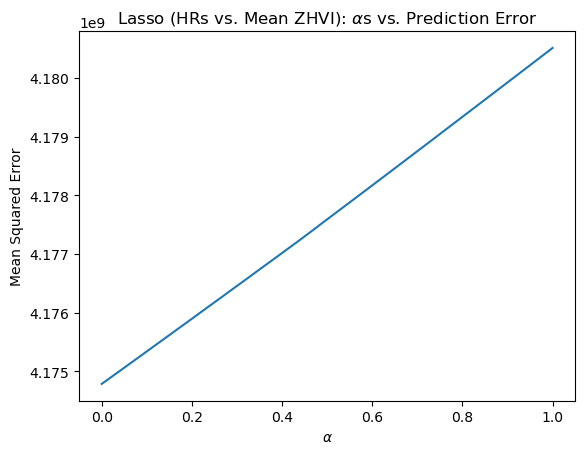

In [21]:
# Conduct LASSO Regression on mean ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_mean"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_mean"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Note: Code inspired by and borrowed from review session + homework 2
# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_mean_no_X = None
opt_alpha_lasso_mean_no_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
alphas = np.linspace(1e-6, 1, num=50)
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_mean_no_X = alphas[counter]
        opt_coefs_lasso_mean_no_X = model['lasso'].coef_
    counter += 1
    
print(opt_alpha_lasso_mean_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs vs. Mean ZHVI): $\alpha$s vs. Prediction Error') # Note here that HR stands for hazard risk
plt.savefig(path + '\\Figures\\LASSO\\alphaMeanZHVILASSO.png')
plt.show()

c:\Users\garvg\anaconda3\envs\mlta\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.599e+12, tolerance: 1.499e+09
  model = cd_fast.enet_coordinate_descent(


0.7755104285714286


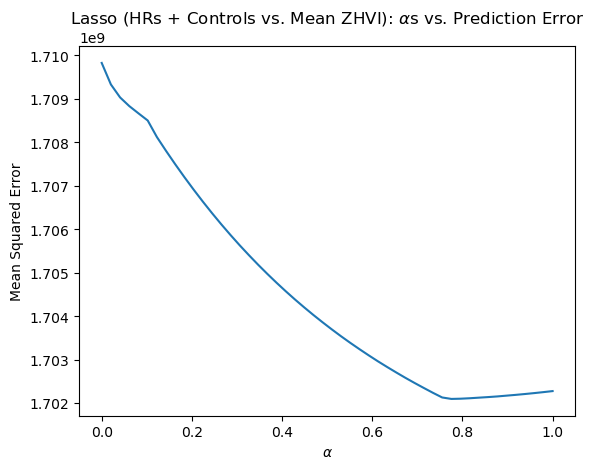

In [22]:
# Conduct LASSO Regression on mean ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_mean"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_mean"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_mean_X = None
opt_alpha_lasso_mean_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
alphas = np.linspace(1e-6, 1, num=50)
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_mean_X = alphas[counter]
        opt_coefs_lasso_mean_X = model['lasso'].coef_
    counter += 1
    
print(opt_alpha_lasso_mean_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs + Controls vs. Mean ZHVI): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaXMeanZHVILASSO.png')
plt.show()

1e-06


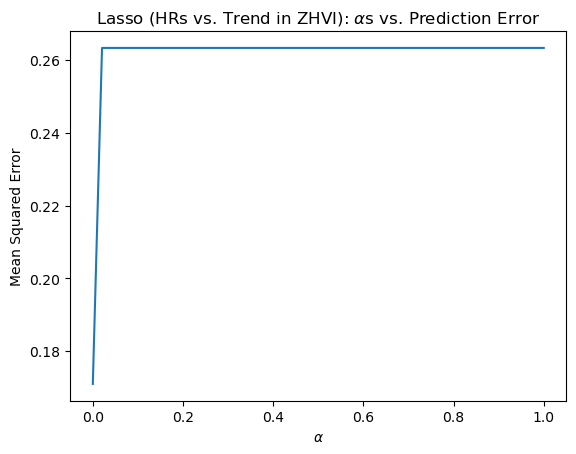

In [23]:
# Conduct LASSO Regression on change in ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_trend"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_trend"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Note: Code also inspired by and borrowed from review session
# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_trend_no_X = None
opt_alpha_lasso_trend_no_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
alphas = np.linspace(1e-6, 1, num=50)
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_trend_no_X = alphas[counter]
        opt_coefs_lasso_trend_no_X = model['lasso'].coef_
    counter += 1
    
print(opt_alpha_lasso_trend_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs vs. Trend in ZHVI): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaTrendZHVILASSO.png')
plt.show()

1e-06


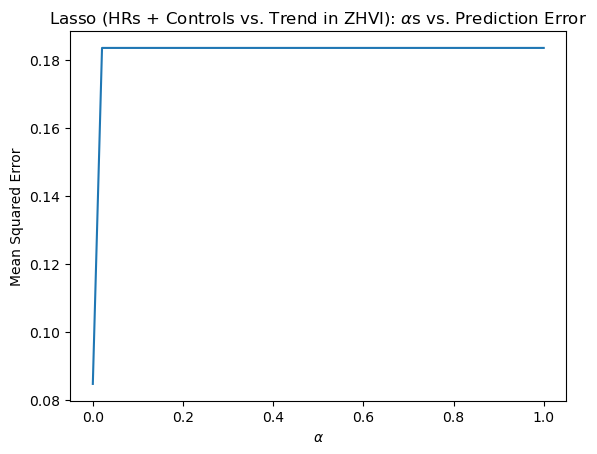

In [24]:
# Conduct LASSO Regression on change in ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_trend"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_trend"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_trend_X = None
opt_alpha_lasso_trend_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
alphas = np.linspace(1e-6, 1, num=50)
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_trend_X = alphas[counter]
        opt_coefs_lasso_trend_X = model['lasso'].coef_
    counter += 1
    
print(opt_alpha_lasso_trend_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs + Controls vs. Trend in ZHVI): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaXTrendZHVILASSO.png')
plt.show()

1e-06


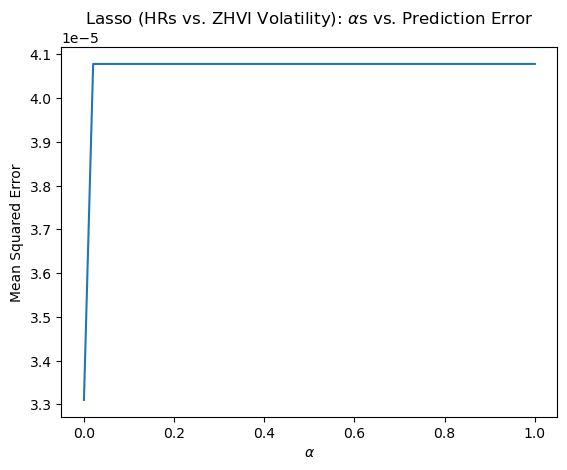

In [25]:
# Conduct LASSO Regression on yearly volatility in ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_vol"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_vol"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_vol_no_X = None
opt_alpha_lasso_vol_no_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
alphas = np.linspace(1e-6, 1, num=50)
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_vol_no_X = alphas[counter]
        opt_coefs_lasso_vol_no_X = model['lasso'].coef_
    counter += 1
    
print(opt_alpha_lasso_vol_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs vs. ZHVI Volatility): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaVolZHVILASSO.png')
plt.show()

1e-06


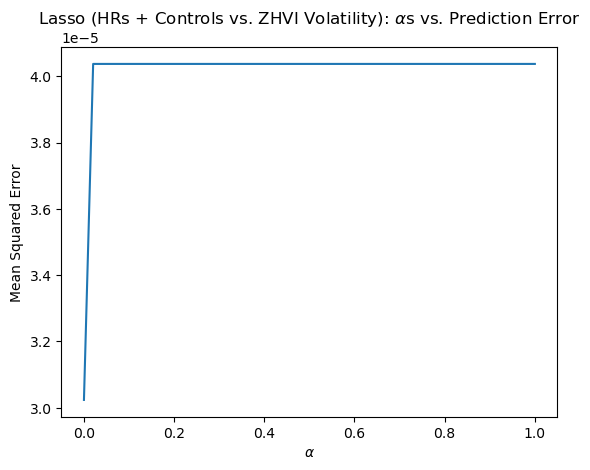

In [26]:
# Conduct LASSO Regression on yearly volatility in ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_vol"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_vol"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_lasso = []
opt_coefs_lasso_vol_X = None
opt_alpha_lasso_vol_X = 0
min_MSE = 0
counter = 0

# Define alphas and models
alphas = np.linspace(1e-6, 1, num=50)
lasso_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Lasso(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]

# Train and test models
for model in lasso_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_lasso.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_lasso_vol_X = alphas[counter]
        opt_coefs_lasso_vol_X = model['lasso'].coef_
    counter += 1
    
print(opt_alpha_lasso_vol_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_lasso)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Lasso (HRs + Controls vs. ZHVI Volatility): $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\LASSO\\alphaXVolZHVILASSO.png')
plt.show()

### Ridge

We conduct this analysis for the same reason as LASSO: to assess variable selection and dimension reduction.

1e-06


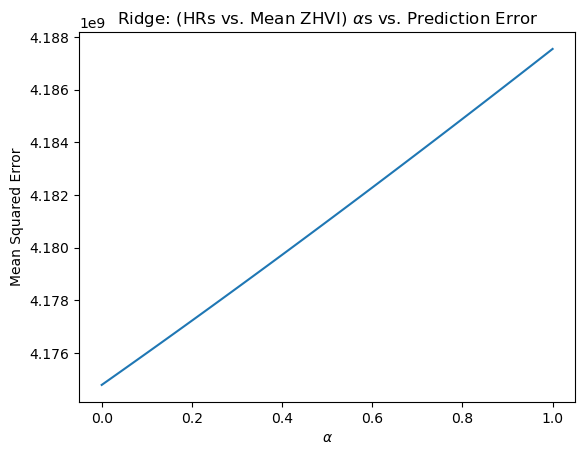

In [27]:
# Conduct Ridge Regression on mean ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_mean"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_mean"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_mean_no_X = None
opt_alpha_ridge_mean_no_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_mean_no_X = alphas[counter]
        opt_coefs_ridge_mean_no_X = model['ridge'].coef_
    counter += 1
    
print(opt_alpha_ridge_mean_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs vs. Mean ZHVI) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaMeanZHVIRidge.png')
plt.show()

0.5306127142857143


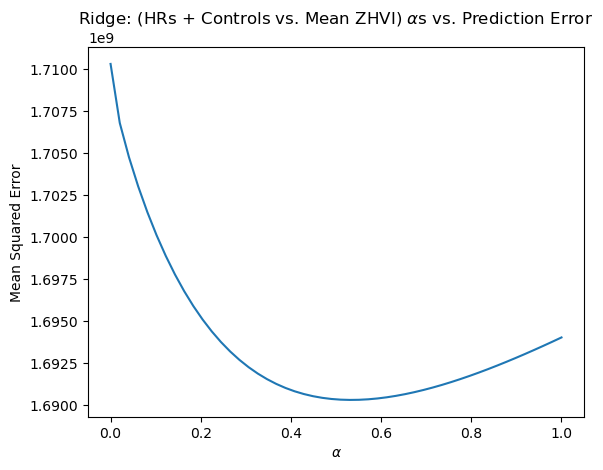

In [28]:
# Conduct Ridge Regression on mean ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_mean"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_mean"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_mean_X = None
opt_alpha_ridge_mean_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_mean_X = alphas[counter]
        opt_coefs_ridge_mean_X = model['ridge'].coef_
    counter += 1
    
print(opt_alpha_ridge_mean_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs + Controls vs. Mean ZHVI) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaXMeanZHVIRidge.png')
plt.show()

1e-06


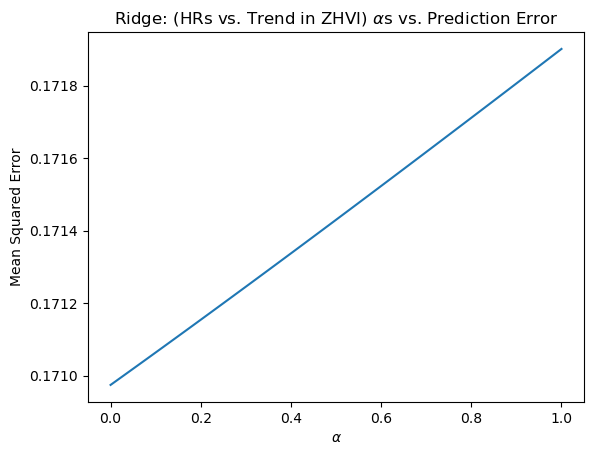

In [29]:
# Conduct Ridge Regression on change in ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_trend"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_trend"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_trend_no_X = None
opt_alpha_ridge_trend_no_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_trend_no_X = alphas[counter]
        opt_coefs_ridge_trend_no_X = model['ridge'].coef_
    counter += 1
    
print(opt_alpha_ridge_trend_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs vs. Trend in ZHVI) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaTrendZHVIRidge.png')
plt.show()

0.24489871428571428


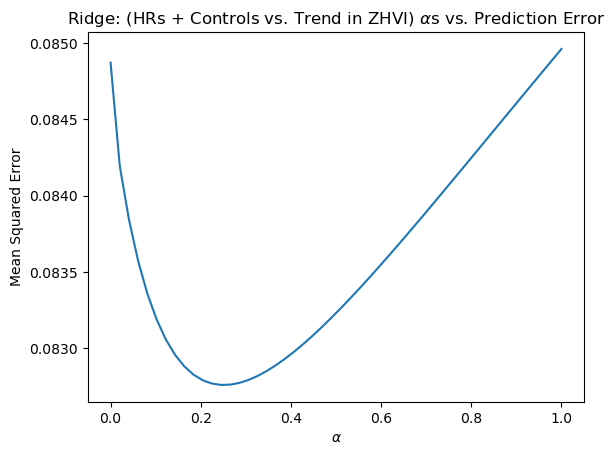

In [30]:
# Conduct Ridge Regression on change in ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_trend"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_trend"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_trend_X = None
opt_alpha_ridge_trend_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_trend_X = alphas[counter]
        opt_coefs_ridge_trend_X = model['ridge'].coef_
    counter += 1
    
print(opt_alpha_ridge_trend_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs + Controls vs. Trend in ZHVI) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaXTrendZHVIRidge.png')
plt.show()

1e-06


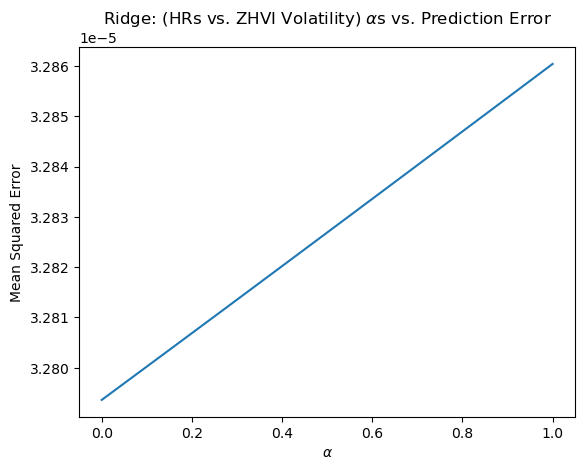

In [31]:
# Conduct Ridge Regression on mean yearly variance in ZHVI (without controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + ["ZHVI_vol"])
working_xs = mod_working_data[hr_vars]
working_ys = mod_working_data["ZHVI_vol"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_vol_no_X = None
opt_alpha_ridge_vol_no_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_vol_no_X = alphas[counter]
        opt_coefs_ridge_vol_no_X = model['ridge'].coef_
    counter += 1
    
print(opt_alpha_ridge_trend_no_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs vs. ZHVI Volatility) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaVolZHVIRidge.png')
plt.show()

0.24489871428571428


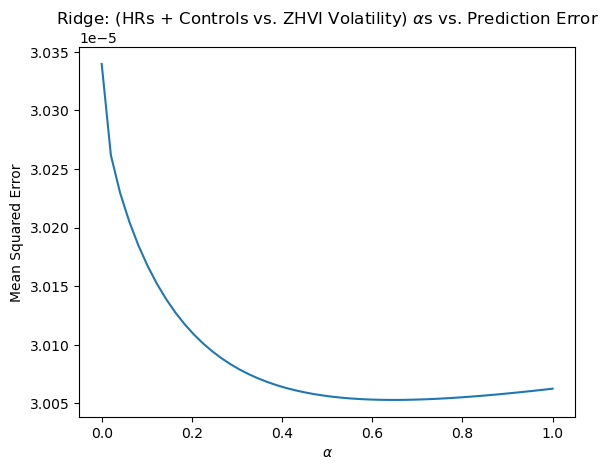

In [32]:
# Conduct Ridge Regression on mean yearly variance in ZHVI (with controls)

# Drop nan observations and split data

mod_working_data = working_data.dropna(subset=hr_vars + control_vars + ["ZHVI_vol"])
working_xs = mod_working_data[hr_vars + control_vars]
working_ys = mod_working_data["ZHVI_vol"]

X_train, X_test, y_train, y_test = train_test_split(working_xs, working_ys, test_size=0.1, random_state=1680)

# Construct vectors to store mean prediction errors and coefficients
cv_errs_ridge = []
opt_coefs_ridge_vol_X = None
opt_alpha_ridge_vol_X = 0
min_MSE = 0
counter = 0

# Define models
ridge_models = [make_pipeline(StandardScaler(with_mean=False), 
                             Ridge(alpha=alpha * np.sqrt(X_train.shape[0]), max_iter=10000)) for alpha in alphas]
# Train and test models
for model in ridge_models:
    # Fit model, evaluate using testing data, and compute mean-squared error
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    
    # Store prediction error
    cv_errs_ridge.append(MSE)
    
    # If we are on the first model or a model with less than minimum prediction error
    #   update new minimum, optimized alpha, and associated coefficients
    if counter == 0 or MSE < min_MSE:
        min_MSE = MSE
        opt_alpha_ridge_vol_X = alphas[counter]
        opt_coefs_ridge_vol_X = model['ridge'].coef_
    counter += 1
    
print(opt_alpha_ridge_trend_X)

# Plot alphas against prediction errors and label
plt.plot(alphas, cv_errs_ridge)
plt.xlabel(r'$\alpha$')
plt.ylabel('Mean Squared Error')
plt.title(r'Ridge: (HRs + Controls vs. ZHVI Volatility) $\alpha$s vs. Prediction Error')
plt.savefig(path + '\\Figures\\Ridge\\alphaXVolZHVIRidge.png')
plt.show()

### Coefficient Comparison: OLS vs. LASSO vs. Ridge Regressions

Notice here that the inputs to the LASSO and Ridge regressions are scaled, which leads to non-comparable magnitudes for these regressions. We can interpret LASSO and Ridge coefficients in terms of prediction importance.

In [33]:
# Mean ZHVI (no controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars,
    'val_ols' : mean_ols_no_X.params.tolist(), 
    'val_lasso' : opt_coefs_lasso_mean_no_X, 
    'var_ridge' : opt_coefs_ridge_mean_no_X
})

print("Mean ZHVI vs. Hazard Risk")
print(coef_comp)

Mean ZHVI vs. Hazard Risk
                  var      val_ols     val_lasso     var_ridge
0           Avalanche  1447.167664  18952.225521  18952.225200
1    Coastal Flooding  1153.370979  25494.073344  25494.072809
2           Cold Wave   319.247170   -391.034140   -391.034153
3             Drought   253.160139   -596.479294   -596.479396
4          Earthquake   309.479041    814.761005    814.761311
5                Hail   160.494724  -2824.104035  -2824.104106
6           Heat Wave    78.423589    -44.117339    -44.117482
7           Hurricane   137.826173  -5913.221348  -5913.221018
8           Ice Storm   -41.724568  -1229.984812  -1229.984904
9           Landslide   450.640685   4993.047203   4993.047204
10          Lightning   382.211449  14532.202794  14532.202096
11  Riverine Flooding    37.510053    363.995323    363.995515
12        Strong Wind   222.926886   2512.743314   2512.743061
13            Tornado  -462.742548  -7683.227718  -7683.227273
14            Tsunami  2085.4

In [34]:
# Mean ZHVI (with controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars + control_vars,
    'val_ols' : mean_ols_X.params.tolist(), 
    'val_lasso' : opt_coefs_lasso_mean_X, 
    'var_ridge' : opt_coefs_ridge_mean_X
})

print("Mean ZHVI vs. Hazard Risk + Controls")
print(coef_comp)

Mean ZHVI vs. Hazard Risk + Controls
                             var       val_ols     val_lasso     var_ridge
0                      Avalanche  4.242277e+02   6952.920341   7393.861056
1               Coastal Flooding  2.238344e+02   4942.967483   4925.557714
2                      Cold Wave -2.706276e+02  -9091.547235  -9315.848495
3                        Drought -1.774937e+01    -51.524540    198.033713
4                     Earthquake  4.741345e+00    803.086499    292.698242
5                           Hail -2.202160e+02  -6470.809935  -6450.031837
6                      Heat Wave  1.114673e+01   -236.366312   -282.769900
7                      Hurricane -9.966899e+00     -3.305380   -464.452972
8                      Ice Storm -5.995096e+01  -1583.943466  -1539.950031
9                      Landslide  7.869387e+01   2005.992738   1933.418417
10                     Lightning  1.355170e+02   2690.100996   2451.520928
11             Riverine Flooding  5.729253e+01   1601.353443   

In [35]:
# Trend ZHVI (no controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars,
    'val_ols' : trend_ols_no_X.params.tolist(), 
    'val_lasso' : opt_coefs_lasso_trend_no_X, 
    'var_ridge' : opt_coefs_ridge_trend_no_X
})

print("Trend in ZHVI vs. Hazard Risk")
print(coef_comp)

Trend in ZHVI vs. Hazard Risk
                  var   val_ols  val_lasso  var_ridge
0           Avalanche  0.002238  -0.000317  -0.000402
1    Coastal Flooding  0.004035   0.129998   0.130049
2           Cold Wave  0.002545   0.003477   0.003515
3             Drought  0.001628   0.016512   0.016551
4          Earthquake  0.005570   0.026265   0.026318
5                Hail  0.000932  -0.032165  -0.032175
6           Heat Wave -0.001894  -0.076131  -0.076188
7           Hurricane  0.001280  -0.071403  -0.071491
8           Ice Storm -0.000172  -0.014264  -0.014291
9           Landslide  0.004430   0.061080   0.061083
10          Lightning  0.000359   0.022966   0.023045
11  Riverine Flooding  0.000466   0.012470   0.012484
12        Strong Wind  0.001487   0.021139   0.021276
13            Tornado -0.003530  -0.061508  -0.061650
14            Tsunami  0.005025   0.046149   0.046154
15  Volcanic Activity  0.001713   0.004560   0.004597
16           Wildfire  0.002308   0.035670   0.03568

In [36]:
# Trend ZHVI (with controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars + control_vars,
    'val_ols' : trend_ols_X.params.tolist(), 
    'val_lasso' : opt_coefs_lasso_trend_X, 
    'var_ridge' : opt_coefs_ridge_trend_X
})

print("Trend in ZHVI vs. Hazard Risk + Controls")
print(coef_comp)

Trend in ZHVI vs. Hazard Risk + Controls
                             var       val_ols  val_lasso  var_ridge
0                      Avalanche -5.807765e-04  -0.007146  -0.005030
1               Coastal Flooding  1.956858e-03   0.048439   0.052448
2                      Cold Wave -6.103914e-04  -0.020095  -0.014969
3                        Drought -9.879525e-06  -0.011081  -0.009075
4                     Earthquake  1.258851e-03   0.027814   0.024959
5                           Hail -9.871797e-04  -0.021708  -0.024068
6                      Heat Wave -2.334411e-03  -0.077873  -0.076630
7                      Hurricane -1.985526e-03  -0.052857  -0.047493
8                      Ice Storm -6.940777e-04  -0.022739  -0.019328
9                      Landslide  8.574266e-04   0.028065   0.029444
10                     Lightning  4.719051e-04   0.013221   0.008428
11             Riverine Flooding  4.252825e-04  -0.001751  -0.002609
12                   Strong Wind -7.828291e-06  -0.000603  -0.

In [37]:
# Volatility ZHVI (no controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars,
    'val_ols' : vol_ols_no_X.params.tolist(), 
    'val_lasso' : opt_coefs_lasso_vol_no_X, 
    'var_ridge' : opt_coefs_ridge_vol_no_X
})

print("ZHVI Volatility vs. Hazard Risk")
print(coef_comp)

ZHVI Volatility vs. Hazard Risk
                  var   val_ols  val_lasso  var_ridge
0           Avalanche  0.000017  -0.000000  -0.000116
1    Coastal Flooding  0.000053   0.001195   0.001286
2           Cold Wave  0.000060  -0.000028  -0.000083
3             Drought  0.000067   0.000527   0.000572
4          Earthquake  0.000067   0.000463   0.000508
5                Hail  0.000053   0.000000   0.000118
6           Heat Wave  0.000015   0.000000   0.000066
7           Hurricane  0.000037  -0.000645  -0.000829
8           Ice Storm -0.000033  -0.001099  -0.001130
9           Landslide  0.000057   0.000161   0.000201
10          Lightning -0.000012   0.000046   0.000261
11  Riverine Flooding -0.000005  -0.000027  -0.000129
12        Strong Wind  0.000025  -0.000028  -0.000027
13            Tornado -0.000062  -0.000504  -0.000668
14            Tsunami  0.000035   0.000008   0.000022
15  Volcanic Activity  0.000022   0.000094   0.000116
16           Wildfire  0.000059   0.000949   0.000

In [38]:
# Volatility ZHVI (with controls) coefficient comparison

coef_comp = pd.DataFrame({
    'var' : hr_vars + control_vars,
    'val_ols' : vol_ols_X.params.tolist(), 
    'val_lasso' : opt_coefs_lasso_vol_X, 
    'var_ridge' : opt_coefs_ridge_vol_X
})

print("ZHVI Volatility vs. Hazard Risk + Controls")
print(coef_comp)

ZHVI Volatility vs. Hazard Risk + Controls
                             var       val_ols  val_lasso  var_ridge
0                      Avalanche -1.095254e-05  -0.000022  -0.000138
1               Coastal Flooding  4.103027e-05   0.000806   0.000866
2                      Cold Wave  2.590714e-06  -0.000000   0.000003
3                        Drought  1.774626e-05   0.000409   0.000466
4                     Earthquake  8.579024e-06   0.000192   0.000241
5                           Hail -7.314232e-06  -0.000123  -0.000183
6                      Heat Wave -5.219348e-06  -0.000055  -0.000166
7                      Hurricane -3.387893e-05  -0.000966  -0.001121
8                      Ice Storm -2.395424e-05  -0.000728  -0.000691
9                      Landslide  2.410717e-06   0.000009   0.000044
10                     Lightning  6.806274e-06   0.000099   0.000243
11             Riverine Flooding -1.017695e-05  -0.000269  -0.000357
12                   Strong Wind -2.237952e-06  -0.000009  -